In [1]:
import pandas as pd
import numpy as np
import koreanize_matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import ast
import plotly.express as px

In [2]:
import warnings

# SettingWithCopyWarning 경고 무시
pd.set_option('mode.chained_assignment', None)

# FutureWarning 경고 무시
warnings.filterwarnings('ignore', category=FutureWarning)

In [3]:
accounts_school  = pd.read_csv('./dumps/processed_csv/processed_accounts_school.csv')
accounts_user_contacts  = pd.read_csv('./dumps/processed_csv/processed_accounts_user_contacts.csv')
accounts_user = pd.read_csv('./dumps/processed_csv/processed_accounts_user.csv')
accounts_userquestionrecord = pd.read_csv('./dumps/processed_csv/processed_userquestionrecord.csv')
polls_questionset = pd.read_csv('./dumps/processed_csv/processed_polls_questionset.csv')
accounts_paymenthistory = pd.read_csv('./dumps/processed_csv/processed_accounts_paymenthistory.csv')

accounts_failpaymenthistory = pd.read_csv('./dumps/processed_csv/processed_accounts_failpaymenthistory.csv')

accounts_group = pd.read_csv('./dumps/processed_csv/processed_accounts_group.csv')
accounts_attendance = pd.read_csv('./dumps/votes_csv/accounts_attendance.csv')

## 전처리

### 테이블

In [4]:
# user_id 개별 처리 (str로 바꿔줌)

accounts_user['user_id'] = accounts_user['user_id'].astype(str)
accounts_user['group_id'] = accounts_user['group_id'].astype(str)

accounts_school['id'] = accounts_school['id'].astype(str)
accounts_group['group_id'] = accounts_group['group_id'].astype(str)
accounts_group['school_id'] = accounts_group['school_id'].astype(str)

accounts_paymenthistory['user_id'] = accounts_paymenthistory['user_id'].astype(str)
accounts_failpaymenthistory['user_id'] = accounts_failpaymenthistory['user_id'].astype(str)

accounts_user_contacts['user_id'] = accounts_user_contacts['user_id'].astype(str)
polls_questionset['user_id'] = polls_questionset['user_id'].astype(str)
accounts_userquestionrecord['user_id'] = accounts_userquestionrecord['user_id'].astype(str)
accounts_userquestionrecord['chosen_user_id'] = accounts_userquestionrecord['chosen_user_id'].astype(str)

accounts_attendance['user_id'] = accounts_attendance['user_id'].astype(str)

In [5]:
# id 컬럼명 변경
accounts_school.rename(columns={'id': 'school_id'}, inplace=True)

# 컬럼 데이터 타입 변환
accounts_attendance['attendance_date_list'] = accounts_attendance['attendance_date_list'].apply(ast.literal_eval)

# 리스트 펼쳐진 새로운 df 생성
new_attendance = accounts_attendance.explode('attendance_date_list')

# user_contacts의 id drop
accounts_user_contacts.drop(columns='id', inplace=True)
new_attendance.drop(columns='id', inplace=True)

accounts_paymenthistory['product_hearts'] = accounts_paymenthistory['productId'].apply(lambda x: x.split('.')[1])
accounts_paymenthistory['product_hearts'] = accounts_paymenthistory['product_hearts'].astype(int)

In [6]:
# datetime 변환
accounts_user['created_at'] = pd.to_datetime(accounts_user['created_at']).dt.floor('s')
polls_questionset['created_at'] = pd.to_datetime(polls_questionset['created_at']).dt.floor('s')
accounts_paymenthistory['created_at'] = pd.to_datetime(accounts_paymenthistory['created_at']).dt.floor('s')

accounts_userquestionrecord['created_at'] = pd.to_datetime(accounts_userquestionrecord['created_at']).dt.floor('s')
accounts_userquestionrecord['answer_updated_at'] = pd.to_datetime(accounts_userquestionrecord['answer_updated_at']).dt.floor('s')
accounts_userquestionrecord['answer_updated_at'] = pd.to_datetime(accounts_userquestionrecord['answer_updated_at']) + timedelta(hours=9)

new_attendance['attendance_date_list'] = pd.to_datetime(new_attendance['attendance_date_list']).dt.floor('s')

### 퍼널

In [7]:
# 날짜 조건 생성
funnel_user_cond = (accounts_user['created_at'] >= '2023-05-13') & (accounts_user['created_at'] <= '2024-05-07')
funnel_questionset_cond = (polls_questionset['created_at'] >= '2023-05-13') & (polls_questionset['created_at'] <= '2024-05-07')
funnel_paymenthistory_cond = (accounts_paymenthistory['created_at'] >= '2023-05-13') & (accounts_paymenthistory['created_at'] <= '2024-05-07')
funnel_question_cond = (accounts_userquestionrecord['created_at'] >= '2023-05-13') & (accounts_userquestionrecord['created_at'] <= '2024-05-07')
funnel_attendance_cond = (new_attendance['attendance_date_list'] >= '2023-05-13') & (new_attendance['attendance_date_list'] <= '2024-05-07')

# 날짜 필터링 - 퍼널 df 생성
funnel_user = accounts_user[funnel_user_cond]
funnel_questionset = polls_questionset[funnel_questionset_cond]
funnel_payment = accounts_paymenthistory[funnel_paymenthistory_cond]
funnel_question = accounts_userquestionrecord[funnel_question_cond]
funnel_attendance = new_attendance[funnel_attendance_cond]

## 퍼널 단계

In [8]:
user_columns = ['user_id', 'group_id']
group_columns = ['group_id', 'school_id', 'is_active']

signup = pd.merge(funnel_user[user_columns], accounts_group[group_columns], on='group_id', how='left')
signup = signup[signup['is_active'] == 1]
signup_user = signup['user_id'].unique()

print(f'유입 유저 수: {len(signup_user)}')

유입 유저 수: 301884


In [9]:
question = funnel_question[funnel_question['user_id'].isin(signup_user)]
orig_question_passive_user = question['chosen_user_id'].unique()
question_active_user = question['user_id'].unique()


print(f'능동적 유저: {len(question_active_user)}\
      \n수동적 유저 (오리지널): {len(orig_question_passive_user)}')
print('---------------------------')

# 먼저 합침
question_all_user = np.append(orig_question_passive_user, question_active_user)
print(f'중복제거 전: {len(question_all_user)}')

# unique()로 중복 제거함
question_total_user = np.unique(question_all_user)
print(f'중복제거 후: {len(question_total_user)}')
print('---------------------------')
print(f'참여 유저 수: {len(question_total_user)}')

능동적 유저: 1705      
수동적 유저 (오리지널): 6076
---------------------------
중복제거 전: 7781
중복제거 후: 6095
---------------------------
참여 유저 수: 6095


In [10]:
# 능동, 수동 유저 분리
# 능동, 수동 중복되는 사람 -> 능동으로 볼 수 있음
# 교집합 사람들을 먼저 구하기

question_intersection_df = pd.DataFrame({
    'user_id': question_all_user
})
question_intersection_df = question_intersection_df['user_id'].value_counts(ascending=False).reset_index(name='user_counts')
question_intersection_df = question_intersection_df[question_intersection_df['user_counts'] > 1]

question_intersection_user = question_intersection_df['user_id'].unique()
print(f'교집합 유저 수: {len(question_intersection_user)}')
print(f'능동 유저 중 교집합 유저 비율(%): {round(len(question_intersection_user) / len(question_active_user) * 100, 2)}')

교집합 유저 수: 1686
능동 유저 중 교집합 유저 비율(%): 98.89


In [11]:
# 능동 유저에 이미 교집합 유저가 포함되어 있을태니
# 수동 유저에서 교집합 유저를 뺌
question_passive_df = pd.DataFrame({
    'user_id': orig_question_passive_user
})
question_passive_df = pd.merge(question_passive_df, question_intersection_df, on='user_id', how='left')
question_passive_df.isnull().sum() # null값 있음. null 값을 가지고 있는 유저들이 수동 유저
question_passive_df = question_passive_df[question_passive_df['user_counts'].isnull()]

question_passive_user = question_passive_df['user_id'].unique()
print(f'수동적 유저 수: {len(question_passive_user)}')

수동적 유저 수: 4390


In [ ]:
question_user_df = pd.DataFrame({
    'type': ['passive', 'active'],
    'count': [len(question_passive_user),
                len(question_active_user)]
})
color_map = ['#6386fa', '#fcb04c']
# fig, ax = plt.subplots(figsize=(12, 5))
# ax.pie(x=question_user_df['count'], labels=question_user_df['type'], autopct='%.f%%')
# plt.title('참여 유저의 타입 비율')
# plt.show()

fig = px.pie(data_frame=question_user_df, values='count', names='type', 
             color_discrete_sequence=color_map,
             title='참여 유저의 타입 비율')
fig.update_traces(textposition='outside',textinfo='label+percent+value', textfont_size=15,textfont_color="black")
fig.update_layout(title_x=0.5)
fig.show()


## 참여 유저 패턴 분석

In [12]:
sns.set_palette('pastel')
passive_color = sns.color_palette('pastel')[0]
active_color = sns.color_palette('pastel')[1]

### 질문

In [12]:
# created_at부터 answer_updated_at까지 걸린 기간을 구하려고 함 -> 마이너스가 될만한 요소가 있나? -> 있음!!
# 마이너스 요소들 파악, 분석, 처리방법 필요!

# created_at보다 answer_updated_at가 더 빠른 건 뭐지
# 질문을 먼저 한 다음 답변하면 answer_updated_at가 느리고,
# 답변하지 않으면 answer_updated_at와 같아야 하는데
# 빠른 애들은 오류인가? -> 534개로 극소수이긴 함 -> 0.1%

columns = ['question_id', 'status', 'created_at', 'chosen_user_id', 'user_id', 'has_read', 'answer_status', 'answer_updated_at', 'report_count', 'opened_times']

same_answer = question[question['answer_updated_at'] == question['created_at']][columns] # 377,186개
late_answer = question[question['answer_updated_at'] > question['created_at']][columns] # 50,175개
fast_answer = question[question['answer_updated_at'] < question['created_at']][columns] # 534개

fast_answer

,question_id,status,created_at,chosen_user_id,user_id,has_read,answer_status,answer_updated_at,report_count,opened_times
416099,31743978,C,2023-05-13 08:35:51,1108505,1189500,0,N,2023-05-13 08:35:50,0,0
423450,32705831,C,2023-05-13 11:34:55,1151668,1189770,0,N,2023-05-13 11:34:54,0,0
441956,35077126,C,2023-05-13 17:39:20,841576,1193797,1,N,2023-05-13 17:39:19,0,0
448400,35894054,C,2023-05-13 19:33:14,1142998,1187024,1,N,2023-05-13 19:33:13,0,0
465308,37903579,C,2023-05-13 23:12:09,1208433,1216746,0,N,2023-05-13 23:12:08,0,0
...,...,...,...,...,...,...,...,...,...,...
1211969,160180544,C,2023-07-29 20:40:22,1003443,1301546,1,N,2023-07-29 20:40:21,0,0
1212752,160448124,C,2023-08-06 19:39:11,1425732,1436724,0,N,2023-08-06 19:39:10,0,0
1212895,160500919,C,2023-08-07 19:29:12,1511957,1512864,0,N,2023-08-07 19:29:11,0,0
1213116,160550974,C,2023-08-09 16:29:24,1284139,1214735,1,N,2023-08-09 16:29:23,0,0


In [ ]:
late_answer['answer_status'].value_counts().reset_index()

,answer_status,count
0,A,46463
1,P,3712


In [ ]:
# answer_status가 답변만 있는 것과
# has_read가 1만 있는 것으로 보아
# created_at보다 answer_updated_at가 늦은건
# 확실하게 채팅을 열은 것

late_answer['has_read'].value_counts().reset_index()

,has_read,count
0,1,50175


In [ ]:
# answer_status가 미답변만 있는 것으로 보아
# created_at와 answer_updated_at가 같은건
# 확실하게 채팅한 적이 없어서 투표 기록시간과 같은 거로 찍힌 것
same_answer['answer_status'].value_counts().reset_index()

,answer_status,count
0,N,377186


In [ ]:
same_answer['has_read'].value_counts().reset_index()

,has_read,count
0,1,217279
1,0,159907


In [ ]:
# 얘넨 뭘까
# 시간 차이를 봐야겠음
fast_answer['answer_status'].value_counts().reset_index()

,answer_status,count
0,N,534


In [71]:
fast_answer['has_read'].value_counts().reset_index()

,has_read,count
0,1,305
1,0,229


In [ ]:
# 정리하면,
# 채팅을 활발하게 진행한 것들은 answer_updated_at가 created_at보다 느림
# created_at부터 answer_updated_at까지 걸린 기간은
# 절대값으로 평균 보면 될 듯

fast_answer['has_read'].value_counts().reset_index()

,has_read,count
0,1,258541
1,0,160136


In [13]:
# created_at와 다 1초밖에 차이 안 남
# 오류로 인한 타임 기록이라고 봐도 되지 않을까
# 그리고 1초 차이 이므로 얘네들은 created_at = answer_updated_at로 봐도
# 계산 오차가 크지 않을 듯
fast_answer['diff'] = fast_answer['created_at'] - fast_answer['answer_updated_at']
fast_answer['diff'].value_counts().reset_index()

,diff,count
0,0 days 00:00:01,534


In [14]:
question_time_diff = question[columns]
question_time_diff['diff'] = question_time_diff['answer_updated_at'] - question_time_diff['created_at']

# diff가 마이너스인 애들은 오류인 애들
# 0으로 치환해줌 
question_time_diff.loc[question_time_diff['diff'] < pd.Timedelta(0), 'diff'] = pd.Timedelta(0)
question_time_diff[question_time_diff['diff'] < pd.Timedelta(0)]

,question_id,status,created_at,chosen_user_id,user_id,has_read,answer_status,answer_updated_at,report_count,opened_times,diff


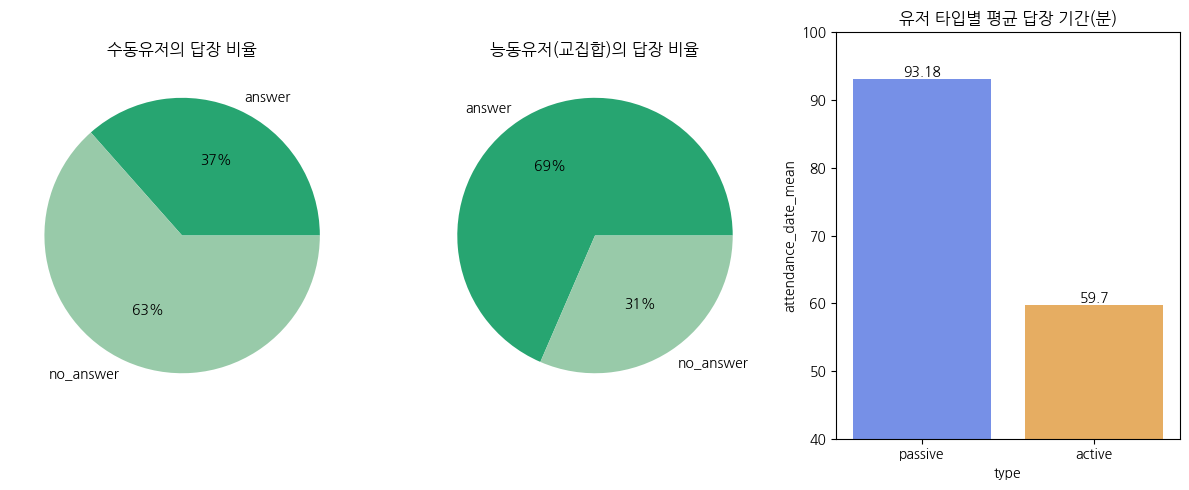

In [16]:
passive_time_diff = question_time_diff[question_time_diff['chosen_user_id'].isin(question_passive_user)]
intersection_time_diff = question_time_diff[question_time_diff['chosen_user_id'].isin(question_intersection_user)]

passive_time_diff_mean = passive_time_diff.groupby('chosen_user_id')['diff'].mean().reset_index()
intersection_time_diff_mean = intersection_time_diff.groupby('chosen_user_id')['diff'].mean().reset_index()

# 평균값이 0일인 유저들 diff 타입 설정
passive_time_diff_mean.loc[passive_time_diff_mean['diff'] <= pd.Timedelta(0), 'diff_type'] = 'no_answer'
passive_time_diff_mean['diff_type'].fillna('answer', inplace=True)
intersection_time_diff_mean.loc[intersection_time_diff_mean['diff'] <= pd.Timedelta(0), 'diff_type'] = 'no_answer'
intersection_time_diff_mean['diff_type'].fillna('answer', inplace=True)

# 그래프 그리기 쉽게 df 수정
passive_diff_counts = passive_time_diff_mean['diff_type'].value_counts().reset_index().sort_values(by='diff_type')
intersection_diff_counts = intersection_time_diff_mean['diff_type'].value_counts().reset_index().sort_values(by='diff_type')
diff_mean = pd.DataFrame({
    'type': ['passive', 'active'],
    'attendance_date_mean': [round(passive_time_diff_mean['diff'].mean().total_seconds() / 60, 2), 
                             round(intersection_time_diff_mean['diff'].mean().total_seconds() / 60, 2)]
})

diff_type_colors = ["#27A571", "#98caa9"]
color_map = ['#6386fa', '#fcb04c']

fig, ax = plt.subplots(1, 3, figsize=(12, 5))
ax[0].pie(x=passive_diff_counts['count'], labels=passive_diff_counts['diff_type'], autopct='%.f%%', colors=diff_type_colors)
ax[1].pie(x=intersection_diff_counts['count'], labels=intersection_diff_counts['diff_type'], autopct='%.f%%', colors=diff_type_colors)
ax[2] = sns.barplot(data=diff_mean, x='type', y='attendance_date_mean', hue='type', palette=color_map, ax=ax[2])

ax[2].bar_label(ax[2].containers[0], fontsize=10)
ax[2].bar_label(ax[2].containers[1], fontsize=10)
ax[2].set_ylim(40, 100)

ax[0].set_title('수동유저의 답장 비율')
ax[1].set_title('능동유저(교집합)의 답장 비율')
ax[2].set_title('유저 타입별 평균 답장 기간(분)') # 투표된 시점으로부터 답장까지

# 어차피 능동유저의 98%가 넘는 비율이 교집합 유저이기도 함
plt.tight_layout()
plt.show()

In [26]:
diff_mean

,type,attendance_date_mean
0,passive,93.18
1,active,59.70


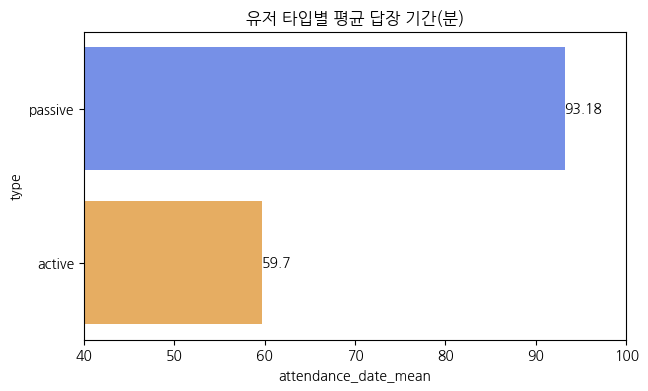

In [ ]:
# 보고서용 임시 그래프
fig, ax = plt.subplots(figsize=(7, 4))
ax = sns.barplot(data=diff_mean, x='attendance_date_mean', y='type', hue='type', palette=color_map)
ax.bar_label(ax.containers[0], fontsize=10)
ax.bar_label(ax.containers[1], fontsize=10)
ax.set_xlim(40, 100)
ax.set_title('유저 타입별 평균 답장 기간(분)')
plt.show()

In [17]:
passive_question = question[question['chosen_user_id'].isin(question_passive_user)]
active_question = question[question['user_id'].isin(question_active_user)]

passive_question_describe = passive_question['chosen_user_id'].value_counts().reset_index()
passive_question_describe = passive_question_describe['count'].describe().reset_index(name='passive_question_counts')

active_question_describe = active_question['user_id'].value_counts().reset_index()
active_question_describe = active_question_describe['count'].describe().reset_index(name='active_question_counts')

# 최대 몇 번이나 투표 받거나 했나 -> 능동유저: 892번 / 능동유저: 1695번 -> 인싸네..
# 한 사람 당 평균적으로 투표에 관여된 횟수 ->  수동유저: 약 26번 / 능동유저: 약 251번
total_question_describe = pd.merge(passive_question_describe, active_question_describe, on='index', how='left')
total_question_describe

,index,passive_question_counts,active_question_counts
0,count,4390.000000,1705.000000
1,mean,26.488610,250.964809
2,std,47.036116,234.274785
3,min,1.000000,1.000000
4,25%,3.000000,87.000000
5,50%,9.000000,183.000000
6,75%,31.000000,335.000000
7,max,892.000000,1695.000000


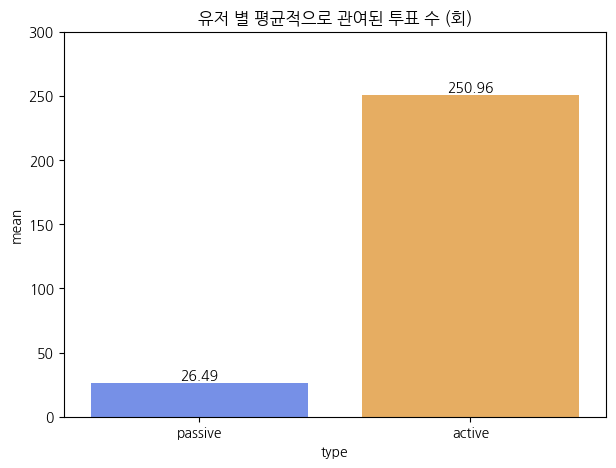

In [19]:
# 가로로 되어 있던 df를 그래프 그리기 편하도록 세로로 변경해줌
total_question_mean = total_question_describe.loc[total_question_describe['index'] == 'mean']
total_question_mean.rename(columns={'passive_question_counts': 'passive', 'active_question_counts': 'active'}, inplace=True)
total_question_mean = total_question_mean[['passive', 'active']].transpose().reset_index()
total_question_mean.rename(columns={'index': 'type', 1: 'mean'}, inplace=True)
total_question_mean['mean'] = round(total_question_mean['mean'], 2)

# 평균적으로 관여된 투표 수를 그린건데,
# 생각해보면 당연히 수동유저들은 투표 받기만을 기다려야 하니까? 
# 상대적으로 적게 나오는 것이 당연할 듯

fig, ax = plt.subplots(figsize=(7, 5))
ax = sns.barplot(data=total_question_mean, x='type', y='mean', hue='type', palette=color_map)
ax.bar_label(ax.containers[0], fontsize=10)
ax.bar_label(ax.containers[1], fontsize=10)
ax.set_ylim(0, 300)

plt.title('유저 별 평균적으로 관여된 투표 수 (회)')
plt.show()

In [20]:
# 시간 차이가 나지 않는 기록들은 전부 미답변 상태
# 읽은 기록이 있기도 하지만 모두 미답변
# 따라서, 시간 차이가 나는 기록들 -> 채팅

test = question_time_diff[question_time_diff['diff'] == pd.Timedelta(0)]
test[test['answer_status'] != 'N']

,question_id,status,created_at,chosen_user_id,user_id,has_read,answer_status,answer_updated_at,report_count,opened_times,diff


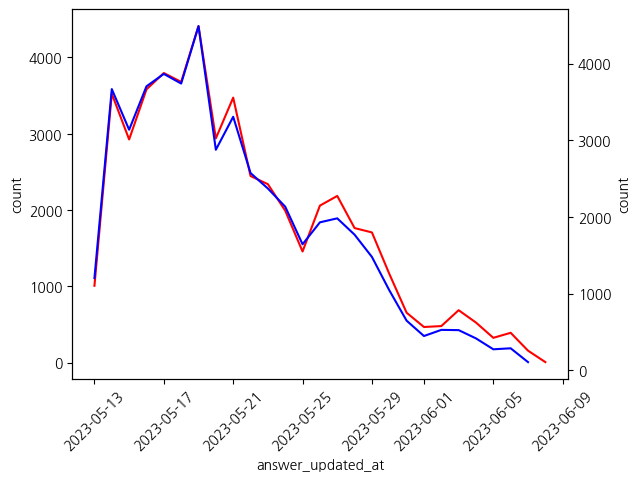

In [21]:
# 그렇다면, 채팅 투표 기록만 추이를 봐보자
# 날짜별 기록된 횟수
# 5월 21일 이후로 계속되는 하락세
# question의 created_at, answer_updated_at 채팅 기록 날짜 범위: 2023-05-13 ~ 2024-05-05
# 근데, 채팅 기록이 확실한 것들 날짜 범위: 2023-05-13 ~ 2023-06-08
# 약 일주일동안 활발한 채팅기록이 생성되다가 6월 초 이후부터는 급격히 사라진 것을 볼 수 있음

ee = question[question['answer_updated_at'] > question['created_at']][columns]
ex = ee['answer_updated_at'].dt.date
ex1 = ee['created_at'].dt.date
ex = ex.value_counts().reset_index()
ex1 = ex1.value_counts().reset_index()

fig, ax = plt.subplots()
ax = sns.lineplot(data=ex, x='answer_updated_at', y='count', color='red')
ax1 = ax.twinx()
ax1 = sns.lineplot(data=ex1, x='created_at', y='count', color='blue')
ax.tick_params(axis='x', labelrotation=45)
plt.show()

In [22]:
# 수동이다가 능동이 된 유저들의 전환 기간 확인
passive_first = question.groupby('chosen_user_id')['created_at'].min().reset_index()
passive_first.columns = ['user_id', 'first_passive_at']

active_first = question.groupby('user_id')['created_at'].min().reset_index()
active_first.columns = ['user_id', 'first_active_at']

# 둘다 기록을 가지고 있는 user_id가 교집합 유저 (1,686명)
total_first = pd.merge(passive_first, active_first, on='user_id', how='inner')

# 수동 -> 능동 전환된 유저 523명 (전체 교집합 유저의 31%)
converted = total_first[total_first['first_passive_at'] < total_first['first_active_at']] 

# 평균적으로 13시간 뒤에 능동으로 전환됨
# 중앙값 약 2시간 이내로 능동으로 전환됨
converted['conversion_days'] = converted['first_active_at'] - converted['first_passive_at']
converted['conversion_days'].describe().reset_index()

,index,conversion_days
0,count,523
1,mean,0 days 13:19:56.460803059
2,std,1 days 05:08:22.881296585
3,min,0 days 00:00:01
4,25%,0 days 00:14:41
5,50%,0 days 01:51:51
6,75%,0 days 13:02:08
7,max,9 days 23:40:14


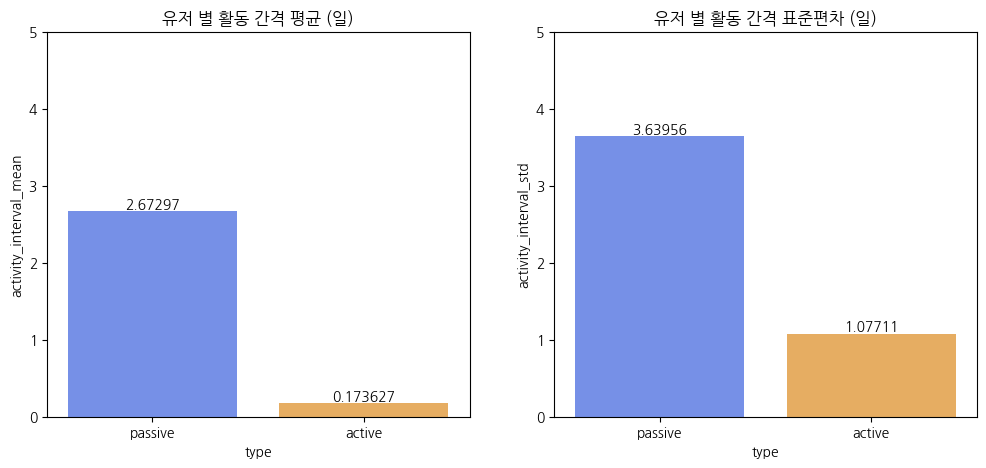

In [23]:
# 유저별 활동 간격 표준편차 확인
# 표준편차로 본 이유: 활동 간격이 일정한지 일정하지 않은지 확인하기 위해
# 활동 패턴 안정성을 볼 수 있음!
# 표준편차가 클수록, 몰아서 들어옴

# 투표 하거나 받은 created_at를 기준으로 함
passive_question_slice = passive_question[['chosen_user_id', 'created_at']]
active_question_slice = active_question[['user_id', 'created_at']]
passive_question_slice.columns = ['user_id', 'created_at']

all_slice = pd.concat([passive_question_slice, active_question_slice], ignore_index=True)
all_slice.dropna(subset=['user_id'], inplace=True) # 혹시나 null 있으면 드롭
all_slice.sort_values(by=['user_id', 'created_at'], inplace=True)

# 유저별 시간 차이 계산
all_slice['time_diff'] = all_slice.groupby('user_id')['created_at'].diff()

# 일 단위로 변환
all_slice['time_diff_days'] = all_slice['time_diff'].dt.total_seconds() / (60*60*24)
user_interval_info = all_slice.groupby('user_id')['time_diff_days'].agg(['mean', 'std']).reset_index() # 평균, 표준편차 둘다 구함
user_interval_info.columns = ['user_id', 'activity_interval_mean', 'activity_interval_std']

user_interval_info['type'] = user_interval_info['user_id'].apply(lambda x: 'passive' if x in question_passive_user else 'active')
user_interval_info_mean = user_interval_info.groupby('type')[['activity_interval_mean', 'activity_interval_std']].mean().reset_index()
user_interval_info_mean.sort_values(by='type', ascending=False, inplace=True)

# 그래프로 정리
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0] = sns.barplot(data=user_interval_info_mean, x='type', y='activity_interval_mean', hue='type', palette=color_map, ax=ax[0])
ax[0].bar_label(ax[0].containers[0], fontsize=10)
ax[0].bar_label(ax[0].containers[1], fontsize=10)
ax[0].set_ylim(0, 5)
ax[0].set_title('유저 별 활동 간격 평균 (일)')

ax[1] = sns.barplot(data=user_interval_info_mean, x='type', y='activity_interval_std', hue='type', palette=color_map, ax=ax[1])
ax[1].bar_label(ax[1].containers[0], fontsize=10)
ax[1].bar_label(ax[1].containers[1], fontsize=10)
ax[1].set_ylim(0, 5)
ax[1].set_title('유저 별 활동 간격 표준편차 (일)')

plt.show()

### 출석

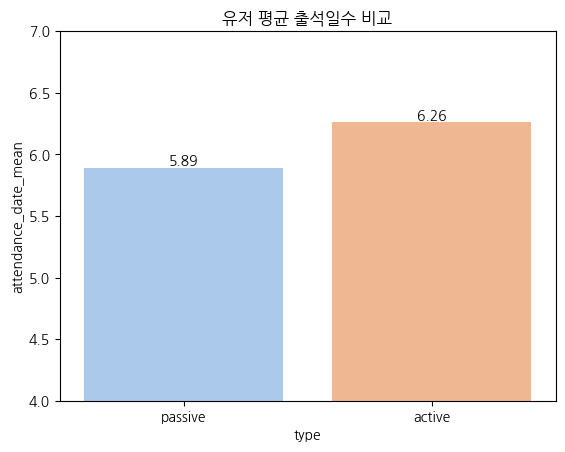

In [ ]:
# 능동, 수동 유저 별 출석일수 비교
passive_attendance = funnel_attendance[funnel_attendance['user_id'].isin(question_passive_user)]
active_attendance = funnel_attendance[funnel_attendance['user_id'].isin(question_active_user)]

passive_attendance_counts = passive_attendance.groupby('user_id')['attendance_date_list'].count().reset_index(name='attendance_date_counts')
active_attendance_counts = active_attendance.groupby('user_id')['attendance_date_list'].count().reset_index(name='attendance_date_counts')

passive_attendance_counts_mean = passive_attendance_counts['attendance_date_counts'].mean()
active_attendance_counts_mean = active_attendance_counts['attendance_date_counts'].mean()

attendance_counts = pd.DataFrame({
    'type': ['passive', 'active'],
    'attendance_date_mean': [round(passive_attendance_counts_mean, 2), 
                             round(active_attendance_counts_mean, 2)]
})

# 출석 일수 별 차이 없었음
ax = sns.barplot(data=attendance_counts, x='type', y='attendance_date_mean', hue='type')
ax.bar_label(ax.containers[0], fontsize=10)
ax.bar_label(ax.containers[1], fontsize=10)
ax.set_title('유저 평균 출석일수 비교')
ax.set_ylim(4, 7)
plt.show()

In [15]:
def make_diff_column(df):
    new_df = pd.DataFrame({})
    for i in range(len(df)):
        df_slice = df.iloc[i: i+1] # df용
        df_slice_compare = df_slice.iloc[0] # 조건 비교용. 이렇게 안 하면 값이 index있는 df 형식으로 나옴
        
        if df_slice_compare['user_id'] == df_slice_compare['before_user_id']: # 이전행, 현재행의 user_id가 같으면
            diff = df_slice_compare['attendance_date_list'] - df_slice_compare['before_attendance_date'] # 날짜 차이 구함
            df_slice['diff'] = diff
        else: # 다르면
            df_slice['diff'] = np.nan # null 넣어줌
        
        new_df = pd.concat([new_df, df_slice])
    
    return new_df

# 1번만 출석한 유저는 제외 
passive_no_only_cond = passive_attendance_counts['attendance_date_counts'] > 1
active_no_only_cond = active_attendance_counts['attendance_date_counts'] > 1

passive_no_only_user = passive_attendance_counts[passive_no_only_cond]['user_id'].unique()
passive_attendance_diff = passive_attendance[passive_attendance['user_id'].isin(passive_no_only_user)]
passive_attendance_diff.sort_values(by=['user_id', 'attendance_date_list'], inplace=True)
passive_attendance_diff['before_attendance_date'] = passive_attendance_diff['attendance_date_list'].shift(1)
passive_attendance_diff['before_user_id'] = passive_attendance_diff['user_id'].shift(1)

active_no_only_user = active_attendance_counts[passive_no_only_cond]['user_id'].unique()
active_attendance_diff = active_attendance[active_attendance['user_id'].isin(active_no_only_user)]
active_attendance_diff.sort_values(by=['user_id', 'attendance_date_list'], inplace=True)
active_attendance_diff['before_attendance_date'] = active_attendance_diff['attendance_date_list'].shift(1)
active_attendance_diff['before_user_id'] = active_attendance_diff['user_id'].shift(1)

# 유저들의 평균 출석 기간 차이 df 생성
passive_attendance_diff = make_diff_column(passive_attendance_diff)
active_attendance_diff = make_diff_column(active_attendance_diff)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_30976\3040651416.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  active_no_only_user = active_attendance_counts[passive_no_only_cond]['user_id'].unique()


In [16]:
# diff 평균 구함
passive_attendance_diff_mean = passive_attendance_diff.groupby('user_id')['diff'].mean().reset_index()
passive_attendance_diff_mean = passive_attendance_diff_mean['diff'].mean()

active_attendance_diff_mean = active_attendance_diff.groupby('user_id')['diff'].mean().reset_index()
active_attendance_diff_mean = active_attendance_diff_mean['diff'].mean()

attendance_diff = pd.DataFrame({
    'type': ['passive', 'active'],
    'attendance_diff_mean': [passive_attendance_diff_mean, 
                             active_attendance_diff_mean]
})

# diff df
# 다음 출석일까지 평균적으로 6~7일 정도 걸렸음
# 두 유저타입에서 별 차이 없었음
attendance_diff

,type,attendance_diff_mean
0,passive,6 days 20:46:59.351467567
1,active,6 days 05:42:05.268863574


### 포인트

In [137]:
# 능동, 수동 유저 별 포인트 수 비교
passive_accounts_user = funnel_user[funnel_user['user_id'].isin(question_passive_user)]
active_accounts_user = funnel_user[funnel_user['user_id'].isin(question_active_user)]

passive_point_describe = passive_accounts_user['point'].describe().reset_index(name='passive_points')
active_point_describe = active_accounts_user['point'].describe().reset_index(name='active_points')

# 포인트 describe는 별 차이 없음
# 굳이 따지면, max 차이
pd.merge(passive_point_describe, active_point_describe, on='index', how='left')

,index,passive_points,active_points
0,count,2289.000000,1705.000000
1,mean,1856.138488,1902.633431
2,std,2013.514332,2021.655629
3,min,4.000000,0.000000
4,25%,488.000000,465.000000
5,50%,1231.000000,1235.000000
6,75%,2503.000000,2643.000000
7,max,18803.000000,15951.000000


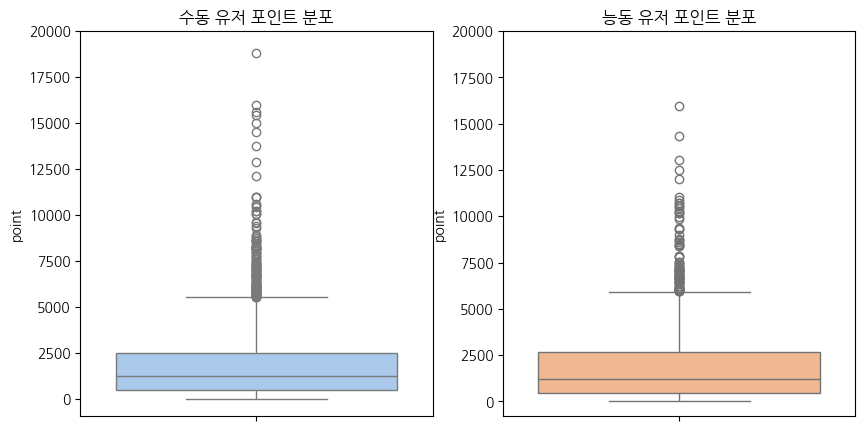

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0] = sns.boxplot(data=passive_accounts_user, y='point', ax=ax[0], color=passive_color)
ax[1] = sns.boxplot(data=active_accounts_user, y='point', ax=ax[1], color=active_color)

ax[0].set_title('수동 유저 포인트 분포')
ax[1].set_title('능동 유저 포인트 분포')

ax[0].set_yticks(range(0, 20001, 2500))
ax[1].set_yticks(range(0, 20001, 2500))
plt.show()

### 하트 구매 이력

In [32]:
# 능동, 수동 유저 별 구매이력 비교
passive_payment = funnel_payment[funnel_payment['user_id'].isin(question_passive_user)]
active_payment = funnel_payment[funnel_payment['user_id'].isin(question_active_user)]

passive_total_pay = passive_payment.groupby('user_id')['product_hearts'].sum().reset_index(name='total_pay_hearts')
active_total_pay = active_payment.groupby('user_id')['product_hearts'].sum().reset_index(name='total_pay_hearts')

passive_hearts_describe = passive_total_pay['total_pay_hearts'].describe().reset_index(name='passive_hearts')
active_hearts_describe = active_total_pay['total_pay_hearts'].describe().reset_index(name='active_hearts')

# 하트 총 구매 수에서, max부분에서 많이 차이가 남
pd.merge(passive_hearts_describe, active_hearts_describe, on='index', how='left')

,index,passive_hearts,active_hearts
0,count,459.000000,214.000000
1,mean,1417.002179,1260.500000
2,std,2630.790531,1298.907315
3,min,200.000000,200.000000
4,25%,777.000000,777.000000
5,50%,777.000000,777.000000
6,75%,977.000000,977.000000
7,max,44777.000000,10977.000000


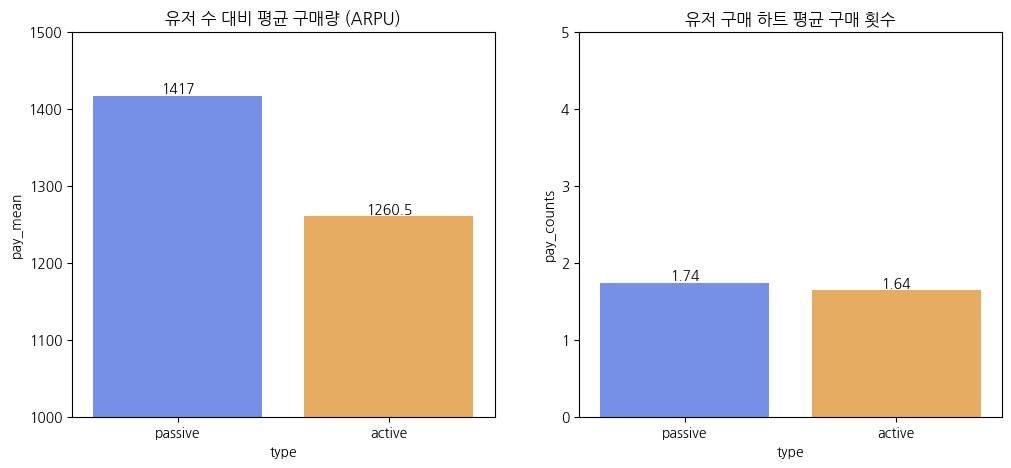

In [33]:
passive_total_pay_mean = passive_total_pay['total_pay_hearts'].mean()
active_total_pay_mean = active_total_pay['total_pay_hearts'].mean()

pay_mean = pd.DataFrame({
    'type': ['passive', 'active'],
    'pay_mean': [round(passive_total_pay_mean, 2), 
                round(active_total_pay_mean, 2)]
})

passive_pay_counts = passive_payment.groupby('user_id')['product_hearts'].count().reset_index(name='pay_count')
active_pay_counts = active_payment.groupby('user_id')['product_hearts'].count().reset_index(name='pay_count')

passive_pay_counts_mean = passive_pay_counts['pay_count'].mean()
active_pay_counts_mean = active_pay_counts['pay_count'].mean()

pay_counts = pd.DataFrame({
    'type': ['passive', 'active'],
    'pay_counts': [round(passive_pay_counts_mean, 2), 
                round(active_pay_counts_mean, 2)]
})

# 수동 유저들이 구매한 하트가 평균적으로 더 많았음
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0] = sns.barplot(data=pay_mean, x='type', y='pay_mean', hue='type', palette=color_map, ax=ax[0])
ax[0].bar_label(ax[0].containers[0], fontsize=10)
ax[0].bar_label(ax[0].containers[1], fontsize=10)
ax[0].set_title('유저 수 대비 평균 구매량 (ARPU)')
ax[0].set_ylim(1000, 1500)

ax[1] = sns.barplot(data=pay_counts, x='type', y='pay_counts', hue='type', palette=color_map, ax=ax[1])
ax[1].bar_label(ax[1].containers[0], fontsize=10)
ax[1].bar_label(ax[1].containers[1], fontsize=10)
ax[1].set_title('유저 구매 하트 평균 구매 횟수')
ax[1].set_ylim(0, 5)

plt.show()

In [35]:
passive_payment['type'] = 'passive'
active_payment['type'] = 'active'

total_payment = pd.concat([passive_payment, active_payment])
total_sum_payment = total_payment.groupby('user_id').agg({'product_hearts': 'sum', 'type': 'min'}).reset_index()
total_sum_payment.rename(columns={'product_hearts': 'total_hearts'}, inplace=True)

total_revenue = total_sum_payment['total_hearts'].sum()
revenue_by_type = total_sum_payment.groupby('type')['total_hearts'].sum().reset_index()
revenue_by_type['contribution_ratio'] = revenue_by_type['total_hearts'] / total_revenue

# 총 구매량 대비 비율 (구매 기여도)
revenue_by_type

,type,total_hearts,contribution_ratio
0,active,269747,0.293155
1,passive,650404,0.706845


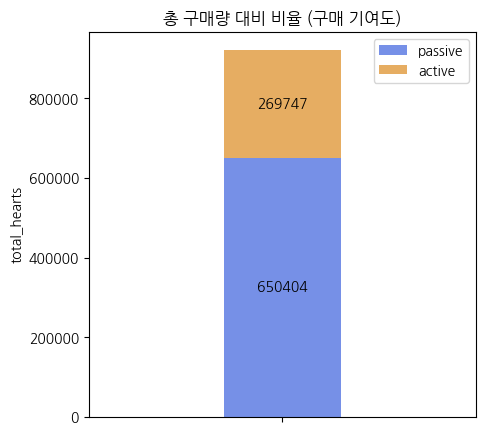

In [37]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.barplot(data=revenue_by_type[revenue_by_type['type'] == 'passive'], y="total_hearts", 
            label='passive', width=0.3, color='#6386fa')
sns.barplot(data=revenue_by_type[revenue_by_type['type'] == 'active'], y="total_hearts",
            bottom=revenue_by_type[revenue_by_type['type'] == 'passive']['total_hearts'], 
            label='active', width=0.3, color='#fcb04c')

for container in ax.containers:
    ax.bar_label(container, label_type='center')

ax.set_title('총 구매량 대비 비율 (구매 기여도)')
plt.show()

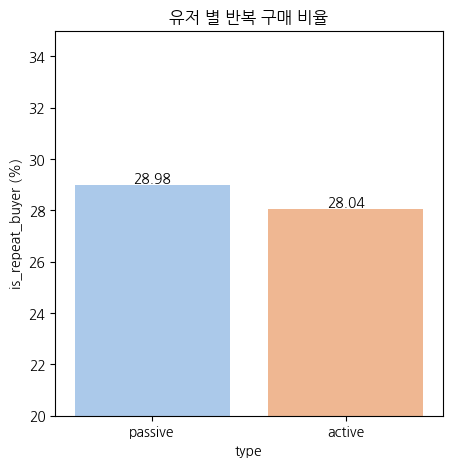

In [233]:
purchase_count = total_payment.groupby('user_id').agg({'product_hearts': 'size', 'type': 'min'}).reset_index()
purchase_count.rename(columns={'product_hearts': 'purchase_count'}, inplace=True)
purchase_count['is_repeat_buyer'] = purchase_count['purchase_count'] > 1 # 반복 구매자 표시

# 유저 별 반복 구매 비율
repeat_rate = purchase_count.groupby('type')['is_repeat_buyer'].mean().reset_index()
repeat_rate['is_repeat_buyer'] = round(repeat_rate['is_repeat_buyer'], 4) * 100
repeat_rate.rename(columns={'is_repeat_buyer': 'is_repeat_buyer (%)'}, inplace=True)
repeat_rate.sort_values(by='type', ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(5, 5))
sns.barplot(data=repeat_rate, x='type', y="is_repeat_buyer (%)", hue='type')
for container in ax.containers:
    ax.bar_label(container)
ax.set_ylim(20, 35)
ax.set_title('유저 별 반복 구매 비율')
plt.show()

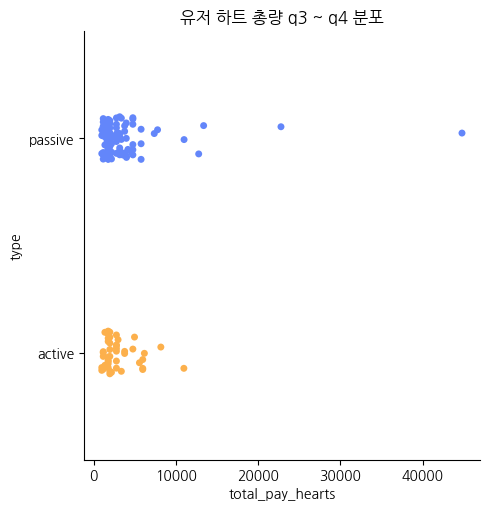

In [21]:
# 하트 75% ~ 비교
# np.percentile(passive_total_pay['total_pay_hearts'], 75)
passive_q3_pay = passive_total_pay[passive_total_pay['total_pay_hearts'] > 977]
active_q3_pay = active_total_pay[active_total_pay['total_pay_hearts'] > 977]

passive_q3_pay['type'] = 'passive'
active_q3_pay['type'] = 'active'

q3_pay = pd.concat([passive_q3_pay, active_q3_pay])

heart_colors = ["#6386fa", "#fcb04c"]
sns.catplot(data=q3_pay, x='total_pay_hearts', y='type', hue='type', palette=heart_colors)
plt.title('유저 하트 총량 q3 ~ q4 분포')
plt.show()

In [162]:
# 해당 유저의 구매 여부 구분 함수
def is_pay(user, user_list):
    if user in user_list:
        return '구매'
    else:
        return '구매 X'

# 구매 유저 구하기
passive_pay_user = passive_total_pay['user_id'].unique()
active_pay_user = active_total_pay['user_id'].unique()
total_pay_user = funnel_payment['user_id'].unique()

# 유저 타입 별 구매 여부 df 생성
passive_is_pay = pd.DataFrame({
    'user_id': question_passive_user
})
active_is_pay = pd.DataFrame({
    'user_id': question_active_user
})

passive_is_pay['is_pay'] = passive_is_pay['user_id'].apply(lambda x: is_pay(x, passive_pay_user))
active_is_pay['is_pay'] = active_is_pay['user_id'].apply(lambda x: is_pay(x, active_pay_user))

passive_is_pay = passive_is_pay['is_pay'].value_counts().reset_index()
active_is_pay = active_is_pay['is_pay'].value_counts().reset_index()

# 전체 유저의 구매 여부 df (기간으로만 전처리한 전체 테이블)
funnel_pay_user_counts = len(funnel_user[funnel_user['user_id'].isin(total_pay_user)])
total_is_pay = pd.DataFrame({
    'is_pay': ['구매', '구매 X'],
    'count': [funnel_pay_user_counts,
              funnel_user['user_id'].nunique() - funnel_pay_user_counts]
})
total_is_pay.sort_values(by='count', ascending=False, inplace=True)

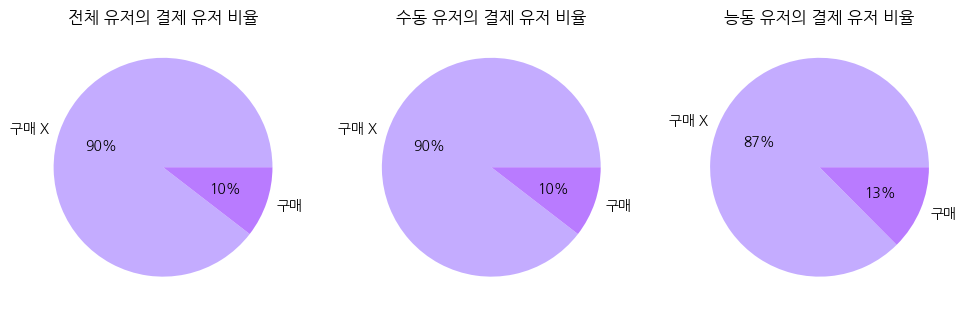

In [163]:
# 구매율 그래프
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
pay_colors = ["#c4acff", "#b97bff"]
ax[0].pie(x=total_is_pay['count'], labels=total_is_pay['is_pay'], autopct='%.f%%', colors=pay_colors)
ax[1].pie(x=passive_is_pay['count'], labels=passive_is_pay['is_pay'], autopct='%.f%%', colors=pay_colors)
ax[2].pie(x=active_is_pay['count'], labels=active_is_pay['is_pay'], autopct='%.f%%', colors=pay_colors)

ax[0].set_title('전체 유저의 결제 유저 비율')
ax[1].set_title('수동 유저의 결제 유저 비율')
ax[2].set_title('능동 유저의 결제 유저 비율')

plt.show()

# 수동유저의 구매 비율이 생각보다 낮음
# 구매 총량은 많았는데..?
# 수동유저는 한 사람이 여러번 사는 경우가 많았나봄

In [ ]:
# 유저별 첫 구매 시점
first_purchase = total_payment.groupby('user_id')['created_at'].min().reset_index()
first_purchase.columns = ['user_id', 'first_purchase_at']

# 유저별 첫 투표 시점
vote_activity = pd.concat([passive_question_slice, active_question_slice], ignore_index=True)
vote_activity.dropna(inplace=True)  # 혹시나 null 있으면 드롭
vote_activity = vote_activity.merge(first_purchase, on='user_id', how='inner')
vote_activity['type'] = vote_activity['user_id'].apply(lambda x: 'passive' if x in question_passive_user else 'active')

# 첫 구매 시점보다 이전 투표 기록만 남김
before_purchase = vote_activity[vote_activity['created_at'] < vote_activity['first_purchase_at']]

# 첫 구매까지 걸리는 평균 투표 횟수
activity_before_purchase = before_purchase.groupby('user_id').agg({'first_purchase_at': 'size', 'type': 'min'}).reset_index()
activity_before_purchase.rename(columns={'first_purchase_at': 'vote_count_before_purchase'}, inplace=True)
activity_before_purchase_describe = activity_before_purchase.groupby('type')['vote_count_before_purchase'].describe().reset_index()
activity_before_purchase_describe

,type,count,mean,std,min,25%,50%,75%,max
0,active,212.0,85.358491,95.845421,1.0,23.0,58.5,109.5,714.0
1,passive,235.0,13.570213,23.106368,1.0,2.0,5.0,15.5,157.0


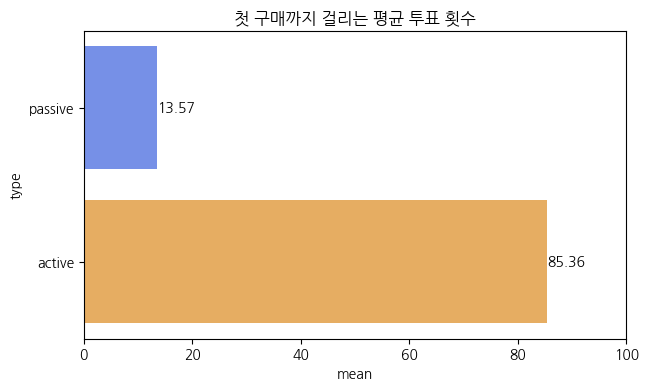

In [48]:
activity_before_purchase_describe.sort_values(by='type', ascending=False, inplace=True)
activity_before_purchase_describe['mean'] = round(activity_before_purchase_describe['mean'], 2)

fig, ax = plt.subplots(figsize=(7, 4))
ax = sns.barplot(data=activity_before_purchase_describe, x='mean', y='type', hue='type', palette=color_map)
for container in ax.containers:
    ax.bar_label(container)
ax.set_xlim(0, 100)
plt.title('첫 구매까지 걸리는 평균 투표 횟수')
plt.show()